'\nCreated on Tue Apr 14 20:12:21 2020\n\n@author: nads\n'

ada sejumlah berita dari jawa timur yang hari ini mencuri perhatian banyak pembaca mulai dari cerita mantan pemulung yang jadi miliarder dengan membudidayakan porang hingga kasus netizen menghina berikut rangkuman beritanya nama paidi tengah menjadi perbincangan pria 37 tahun yang tinggal di desa kepel kecamatan kare kabupaten madiun ini menjadi seorang miliarder setelah membudidayakan dulu pria berambut gondrong itu hidup serba kekurangan saat bekerja serabutan bahkan ia pernah menjalani hidup sebagai pemulung dulu saya tanam porang sejak tahun 2010 dan sebelumnya waktu itu saya kerja serabutan jadi saya kerja apa saja saya jalani mulai jual tahu jual ayam jual buah sampai bangkrut semua sampai akhirnya jadi pemulung ujar paidi di kebun porang yang ada di dekat rumahnya selasa 4 2 2020 setelah menjadi pemulung ada temannya yang mengenalkan tanaman porang yang memiliki nilai jual tinggi saat itu pria berperawakan kurus itu berusaha mencari referensi melalui internet tentang kegunaan po

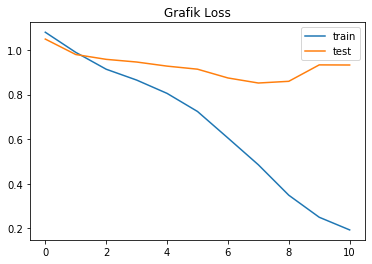

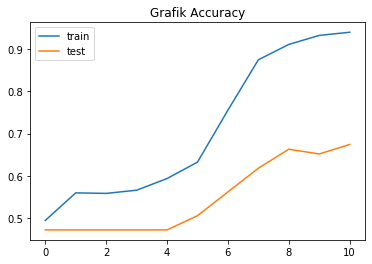

1880


Saved model to disk


In [3]:
# -*- coding: utf-8 -*-
"""
Created on Tue Apr 14 20:12:21 2020

@author: nads
"""

import re
import pandas as pd
import matplotlib.pyplot as plt
import json
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
# import cufflinks
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# cufflinks.go_offline()
# cufflinks.set_config_file(world_readable=True, theme='pearl')

df = pd.read_csv('prepare-data/final_datas.csv')

#   Text Preprocess
def print_plot(index):
    example = df[df.index == index][['descs', 'class']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Class:', example[1])
print_plot(10)

df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
NON_APLHANUM_RE = re.compile('[^\w]')
                              
#   stopword removal
#STOPWORDS = set(stopwords.words('indonesian'))

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def clean_text(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = NON_APLHANUM_RE.sub(' ', text)
    text = text.replace('x', '')
#    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
   #    sastrawi
    output   = stemmer.stem(text)
#     stop_words = factory.get_stop_words()
#     stopper_words = [word for word in text.split() if word not in stop_words]
#     text = ' '.join(stopper_words)
    return output
df['descs'] = df['descs'].apply(clean_text)

MAX_NB_WORDS = 3500
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 300

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, 
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['descs'].values)
word_index = tokenizer.word_index
print('\nFound %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(df['descs'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

#sequence to class
Y = pd.get_dummies(df['class']).values
print('Shape of label tensor:', Y.shape)

#   split data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

#   add layer embedding, lstm, dense
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy']) 
print(model.summary())

#   fit and evaluate model
epochs = 20
batch_size = 128

history = model.fit(X_train, Y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.2%}\n  Accuracy: {:0.2%}'.format(accr[0],
      accr[1]))

#   Print loss and acc plot
def show_plot(title, train_type, val_type):
    plt.title(title)
    plt.plot(history.history[train_type], label='train')
    plt.plot(history.history[val_type], label='test')
    plt.legend()
    plt.show()

show_plot('Grafik Loss', 'loss', 'val_loss')
show_plot('Grafik Accuracy', 'acc', 'val_acc')

target_dir = 'model/'

#   Save dictionary words
with open(target_dir + "dictionary.json", "w") as dictionary_file:
    json.dump(word_index, dictionary_file)
    
#   Save model
model_json = model.to_json()
with open(target_dir + "new_model.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights(target_dir + "new_model.h5")
print('\nSaved model to disk')